In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rho_plus as rp

theme, cs = rp.mpl_setup(False)

torch.manual_seed(42)
device = 'cuda'

In [44]:
from torch.utils.data import Dataset, DataLoader, random_split

batch_size = 256
target = 'delta_e'
dataset_split = 0

class MyDataset(Dataset):
    def __init__(self, inputs, target):
        self.inputs = inputs.values.astype(np.float32)
        self.labels = target.values.astype(np.float32)

        self.inputs = torch.from_numpy(self.inputs).to(device)
        self.labels = torch.from_numpy(self.labels).to(device)

    @property
    def dim_x(self) -> int:
        return self.inputs.shape[1]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index].unsqueeze(0)

    def getSALdata(self):
        input = self.inputs.cpu().numpy()
        label = self.labels.cpu().numpy()
        return (input, label)


all_data = pd.read_feather('mpc_full_feats_scaled_split.feather')
all_data.drop(columns=['comp', 'TSNE_x', 'TSNE_y', 'umap_x', 'umap_y'], inplace=True)

label_cols = ['magmom_pa', 'bandgap', 'delta_e']
all_test_sets = [
    'Xshift_tsne',
    'Xshift_umap',
    'statY_delta_e',
    'infoY_delta_e',
    'statY_bandgap',
    'infoY_bandgap',
    'Rsplt1',
    'Rsplt2',
    'Rsplt3',
    'Rsplt4',
    'Rsplt5',
    'piezo',
]

input_cols = [
    c for c in all_data.columns if c not in all_test_sets + label_cols + ['dataset_split']
]
test_set_flags = all_data[all_test_sets]

in_split = all_data['dataset_split'] >= dataset_split
inputs = all_data.loc[in_split & (~test_set_flags).all(axis=1)]
print(inputs[input_cols].shape)

train_dataset = MyDataset(inputs[input_cols], inputs[target])

# use 20% of training data for validation
train_set_size = int(len(train_dataset) * 0.8)
valid_set_size = len(train_dataset) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_dataset, valid_dataset = random_split(train_dataset, [train_set_size, valid_set_size], generator=seed)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

del all_data
import gc
gc.collect()

(22483, 145)


23593

In [45]:
import lightning as L

class PandasLogger(L.pytorch.loggers.Logger):
    def __init__(self):
        super().__init__()
        self.rows = []

    def log_hyperparams(self, params, *args, **kwargs):
        pass

    def log_metrics(self, metrics, step=None):
        model_type = 'none'
        row = {'step': step}
        for k in metrics:
            if k.startswith('valid_') and metrics[k] is not None:
                model_type = 'valid'
                row[k.removeprefix('valid_')] = metrics[k]
            elif k.startswith('train_') and metrics[k] is not None:
                model_type = 'train'
                row[k.removeprefix('train_')] = metrics[k]
            elif k.startswith('test_') and metrics[k] is not None:
                model_type = 'test'
                row[k.removeprefix('test_')] = metrics[k]
            else:
                row[k] = metrics[k]

        row['step'] = step
        row['kind'] = model_type
        self.rows.append(row)

    @property
    def version(self):
        return 0

    @property
    def name(self):
        return 'pandas'

    def finalize(self, status):
        self.df = pd.DataFrame(self.rows)

In [46]:
from typing import Any
class IRNet_intorch(L.LightningModule):
    #'128-64-16'
    def __init__(self, input_size, dims=(1024, 512, 256, 128, 64, 32), lr=1e-4):
        super(IRNet_intorch, self).__init__()
        self.dims = dims
        self.lr = lr

        self.adapters = []
        self.layers = []
        i = 0
        prev_dim = input_size
        for dim in dims:
            fc = nn.Linear(prev_dim, dim)
            bn = nn.BatchNorm1d(dim)
            act = nn.ReLU()
            mod = nn.Sequential(fc, bn, act)
            self.add_module(f'layer{i}', mod)
            self.layers.append(mod)

            if dim != prev_dim:
                adapter = nn.Linear(prev_dim, dim)
                self.add_module(f'adapter{i}', adapter)
                self.adapters.append(adapter)
            else:
                self.adapters.append(None)

            prev_dim = dim
            i += 1

        self.out = nn.Linear(dim, 1)

    def forward(self, x):
        out = x
        for layer, adapter in zip(self.layers, self.adapters):
            if adapter is not None:
                out_res = adapter(out)
            else:
                out_res = 0
            out = layer(out) + out_res

        return self.out(out)

    def loss(self, batch, batch_idx):
        inputs, target = batch
        output = self(inputs)
        loss = F.smooth_l1_loss(output, target)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.loss(batch, batch_idx)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.loss(batch, batch_idx)
        self.log('valid_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

model = IRNet_intorch(len(input_cols))
model

IRNet_intorch(
  (layer0): Sequential(
    (0): Linear(in_features=145, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (adapter0): Linear(in_features=145, out_features=1024, bias=True)
  (layer1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (adapter1): Linear(in_features=1024, out_features=512, bias=True)
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (adapter2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()

```
IRNet_intorch(
  (fc128): Linear(in_features=128, out_features=128, bias=True)
  (fc64): Linear(in_features=64, out_features=64, bias=True)
  (fc16): Linear(in_features=16, out_features=16, bias=True)
  (bn128): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn64): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn16): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (inputlayer): Linear(in_features=145, out_features=128, bias=True)
  (con128_64): Linear(in_features=128, out_features=64, bias=True)
  (con64_16): Linear(in_features=64, out_features=16, bias=True)
  (output16): Linear(in_features=16, out_features=1, bias=True)
)
```

In [47]:
import lightning.pytorch.callbacks as callbacks
trainer = L.Trainer(logger=PandasLogger(), enable_checkpointing=False, callbacks=[
    # callbacks.LearningRateFinder(min_lr=1e-5, max_lr=1e-2, mode='exponential'),
    callbacks.RichProgressBar()
], max_epochs=100, log_every_n_steps=10)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name     ┃ Type       ┃ Params ┃
┡━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ layer0   │ Sequential │  151 K │
│ 1  │ adapter0 │ Linear     │  149 K │
│ 2  │ layer1   │ Sequential │  525 K │
│ 3  │ adapter1 │ Linear     │  524 K │
│ 4  │ layer2   │ Sequential │  131 K │
│ 5  │ adapter2 │ Linear     │  131 K │
│ 6  │ layer3   │ Sequential │ 33.2 K │
│ 7  │ adapter3 │ Linear     │ 32.9 K │
│ 8  │ layer4   │ Sequential │  8.4 K │
│ 9  │ adapter4 │ Linear     │  8.3 K │
│ 10 │ layer5   │ Sequential │  2.1 K │
│ 11 │ adapter5 │ Linear     │  2.1 K │
│ 12 │ out      │ Linear     │     33 │
└────┴──────────┴────────────┴────────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6

Output()

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connect
or.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value
of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connect
or.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=100` reached.


[0.0010917581372265233, 0.0011920451096869848]

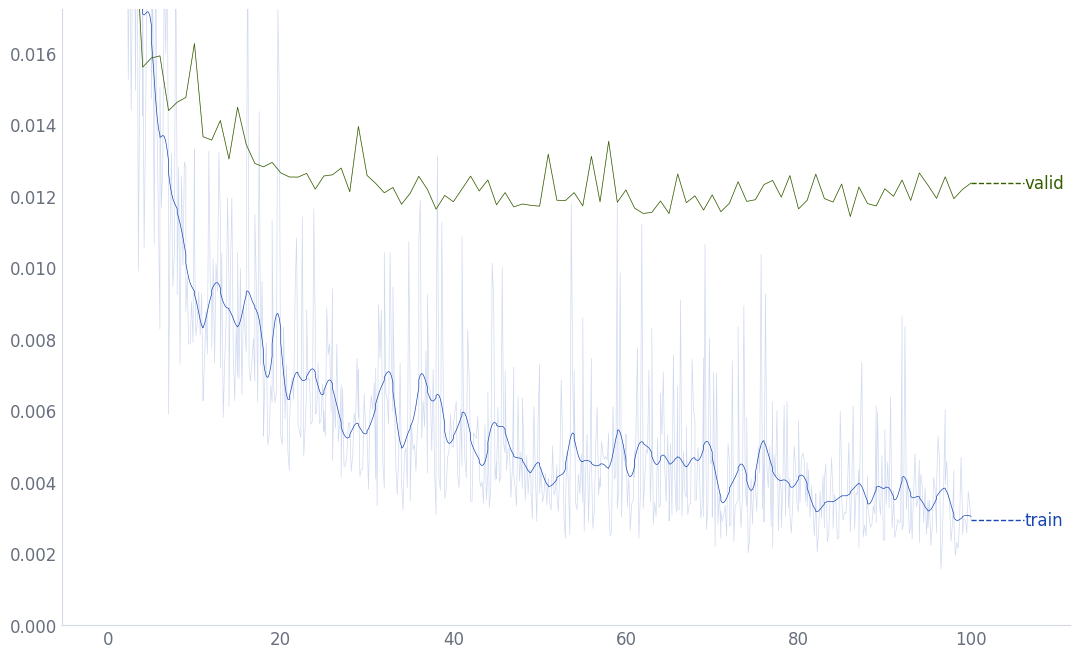

In [48]:
logs = trainer.logger.df
logs['epoch_frac'] = logs['epoch'] + logs.groupby('epoch')['step'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
fig, ax = plt.subplots(figsize=(13, 8))
for kind in sorted(set(logs['kind'])):
    ax.plot('epoch_frac', 'loss', data=logs.query('kind == @kind'), label=kind, lw=0.5)

ax.set_ylim(0, logs[logs['epoch'] == int(logs['epoch'].max() * 0.05)]['loss'].mean())
rp.line_labels()
rp.smooth_noisy_lines()

[0.0010917581372265233, 0.0011920451096869848]

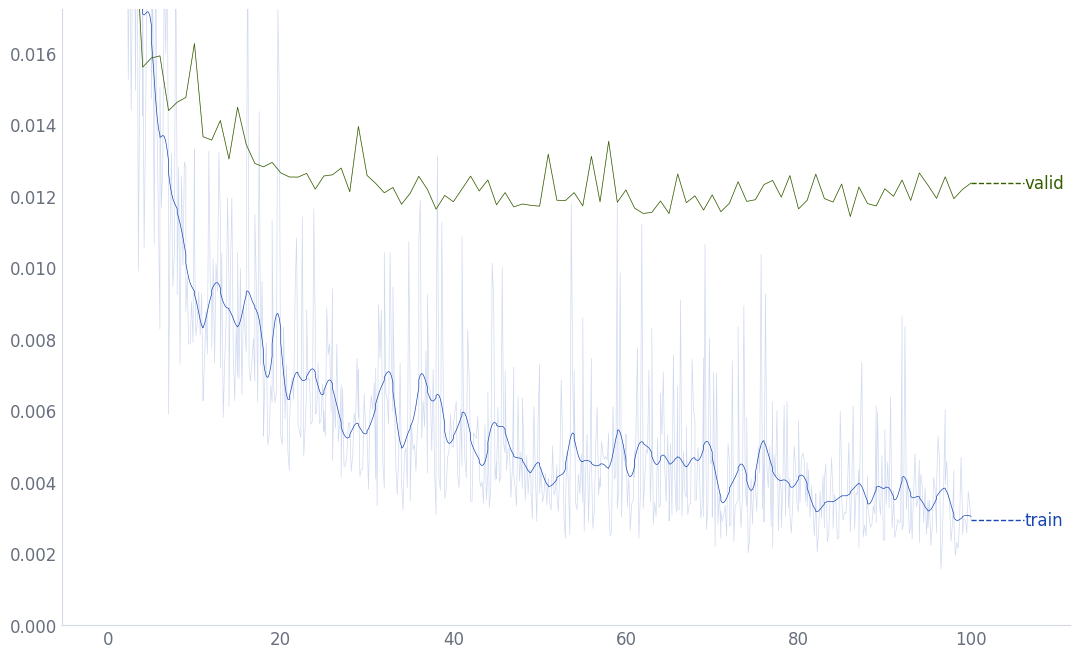

In [49]:
logs = trainer.logger.df
logs['epoch_frac'] = logs['epoch'] + logs.groupby('epoch')['step'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
fig, ax = plt.subplots(figsize=(13, 8))
for kind in sorted(set(logs['kind'])):
    ax.plot('epoch_frac', 'loss', data=logs.query('kind == @kind'), label=kind, lw=0.5)

ax.set_ylim(0, logs[logs['epoch'] == int(logs['epoch'].max() * 0.05)]['loss'].mean())
rp.line_labels()
rp.smooth_noisy_lines()